<a href="https://colab.research.google.com/github/redjules/prophet/blob/main/Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Directory, Libraries and data

In [2]:
#Change directory
%cd /content/drive/MyDrive/Business Analyst course/Predictive Analytics/Prophet

/content/drive/MyDrive/Business Analyst course/Predictive Analytics/Prophet


In [3]:
#Import libraries
import numpy as np
import pandas as pd
from prophet import Prophet

In [4]:
#Data
df = pd.read_csv("Udemy_wikipedia_visits.csv")
df.head()

,Date,Udemy,Easter,Christmas,Black Friday
0,1/1/2016,311,0,0,0
1,1/2/2016,564,0,0,0
2,1/3/2016,517,0,0,0
3,1/4/2016,652,0,0,0
4,1/5/2016,756,0,0,0


In [5]:
#Looking into what kind of variables we have
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          1827 non-null   object
 1   Udemy         1827 non-null   int64 
 2   Easter        1827 non-null   int64 
 3   Christmas     1827 non-null   int64 
 4   Black Friday  1827 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.5+ KB


In [6]:
#Summary statistics
df.describe()

,Udemy,Easter,Christmas,Black Friday
count,1827.000000,1827.000000,1827.000000,1827.000000
mean,943.068418,0.002737,0.002737,0.002737
std,531.341700,0.052256,0.052256,0.052256
min,209.000000,0.000000,0.000000,0.000000
25%,542.500000,0.000000,0.000000,0.000000
50%,832.000000,0.000000,0.000000,0.000000
75%,1175.000000,0.000000,0.000000,0.000000
max,2847.000000,1.000000,1.000000,1.000000


<Axes: >

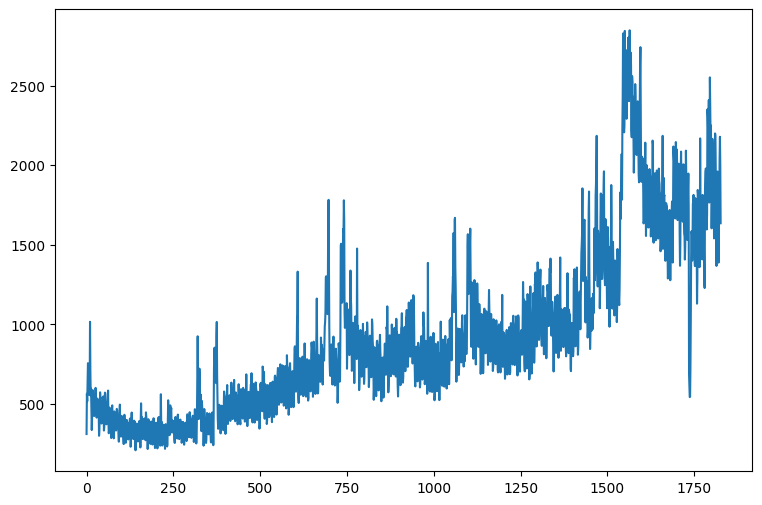

In [7]:
#Plotting
df.Udemy.plot(figsize = (9,6))

#Data Preparation

In [8]:
#Date variable: %m/%d/%Y -> %Y-%m-%d
df.Date = pd.to_datetime(df.Date,
                         format = "%m/%d/%Y")
df.Date

0      2016-01-01
1      2016-01-02
2      2016-01-03
3      2016-01-04
4      2016-01-05
          ...    
1822   2020-12-27
1823   2020-12-28
1824   2020-12-29
1825   2020-12-30
1826   2020-12-31
Name: Date, Length: 1827, dtype: datetime64[ns]

In [9]:
#Change variable: Date -> ds, time-series (Udemy) -> y
df = df.rename(columns = {'Date':'ds',
                          'Udemy': 'y'})
df.head(1)

,ds,y,Easter,Christmas,Black Friday
0,2016-01-01,311,0,0,0


#holidays

In [10]:
#Easter
easter_dates = df[df.Easter == 1].ds
easter = pd.DataFrame({'holiday':'easter',
                      'ds': easter_dates,
                      'lower_window':-5,
                      'upper_window':2})

In [11]:
#Black Friday
bf_dates = pd.to_datetime(df[df['Black Friday'] == 1].ds)
bf = pd.DataFrame({'holiday': 'black_friday',
                         'ds':bf_dates,
                         'lower_window': -7,
                         'upper_window': 5})

In [12]:
#combine the holidays
holidays = pd.concat([easter, bf])
holidays

,holiday,ds,lower_window,upper_window
86,easter,2016-03-27,-5,2
471,easter,2017-04-16,-5,2
821,easter,2018-04-01,-5,2
1206,easter,2019-04-21,-5,2
1563,easter,2020-04-12,-5,2
329,black_friday,2016-11-25,-7,5
693,black_friday,2017-11-24,-7,5
1057,black_friday,2018-11-23,-7,5
1428,black_friday,2019-11-29,-7,5
1792,black_friday,2020-11-27,-7,5


In [13]:
#Remove holidays from the main df (avoid duplicate)
df = df.drop(columns = ["Easter","Black Friday"])
df.head(0)

,ds,y,Christmas


#Prophet Model

In [14]:
#Training and Test Split
test_days = 31
training = df.iloc[:-test_days, : ]
test = df.iloc[-test_days:, : ]
print(test.head(1))
print(training.head(1))


             ds     y  Christmas
1796 2020-12-01  2393          0
          ds    y  Christmas
0 2016-01-01  311          0


In [15]:
#Prophet Model
m = Prophet(growth = 'linear',
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode ='additive',
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05)
m.add_regressor('Christmas', mode = 'multiplicative')
#m.add_regressor('XXXX')
m.fit(training)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp20gq41gp/d4g8p23b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20gq41gp/up538dkl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28163', 'data', 'file=/tmp/tmp20gq41gp/d4g8p23b.json', 'init=/tmp/tmp20gq41gp/up538dkl.json', 'output', 'file=/tmp/tmp20gq41gp/prophet_modelg66f2lvj/prophet_model-20230502143805.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:38:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:38:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [16]:
#Regressor coefficients
from prophet.utilities import regressor_coefficients
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Christmas,multiplicative,0.0,-0.324999,-0.324999,-0.324999


-During Xmas day, the number of visits frop by 29%

#Forecasting

In [17]:
#create future dataframe
future = m.make_future_dataframe(periods = test_days,
                        freq = 'D')
future = pd.concat([future, df.iloc[:,2:]],
                   axis = 1)
future

,ds,Christmas
0,2016-01-01,0
1,2016-01-02,0
2,2016-01-03,0
3,2016-01-04,0
4,2016-01-05,0
...,...,...
1822,2020-12-27,0
1823,2020-12-28,0
1824,2020-12-29,0
1825,2020-12-30,0


In [18]:
#forecasting
forecast = m.predict(future)
forecast.head()
print(forecast.columns)

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas', 'Christmas_lower', 'Christmas_upper', 'additive_terms',
       'additive_terms_lower', 'additive_terms_upper', 'black_friday',
       'black_friday_lower', 'black_friday_upper', 'easter', 'easter_lower',
       'easter_upper', 'extra_regressors_multiplicative',
       'extra_regressors_multiplicative_lower',
       'extra_regressors_multiplicative_upper', 'holidays', 'holidays_lower',
       'holidays_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'yhat'],
      dtype='object')


In [19]:
#Holiday assessment
holiday = 'black_friday'
forecast[(forecast[holiday].abs() > 0) & (forecast['ds'] > '2020-01-01')][['ds', holiday]]

,ds,black_friday
1785,2020-11-20,99.296527
1786,2020-11-21,90.540009
1787,2020-11-22,163.347479
1788,2020-11-23,235.617435
1789,2020-11-24,212.007264
1790,2020-11-25,184.124600
1791,2020-11-26,223.389001
1792,2020-11-27,447.508542
1793,2020-11-28,204.173744
1794,2020-11-29,228.853817


In [20]:
#Retrieve the predictions
predictions = forecast.yhat[-test_days:]

In [21]:
#Accuracy assessment
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_absolute_error(test.y, predictions))
print(np.sqrt(mean_squared_error(test.y, predictions)))

184.5327309354843
236.18722269520234


#Visualization

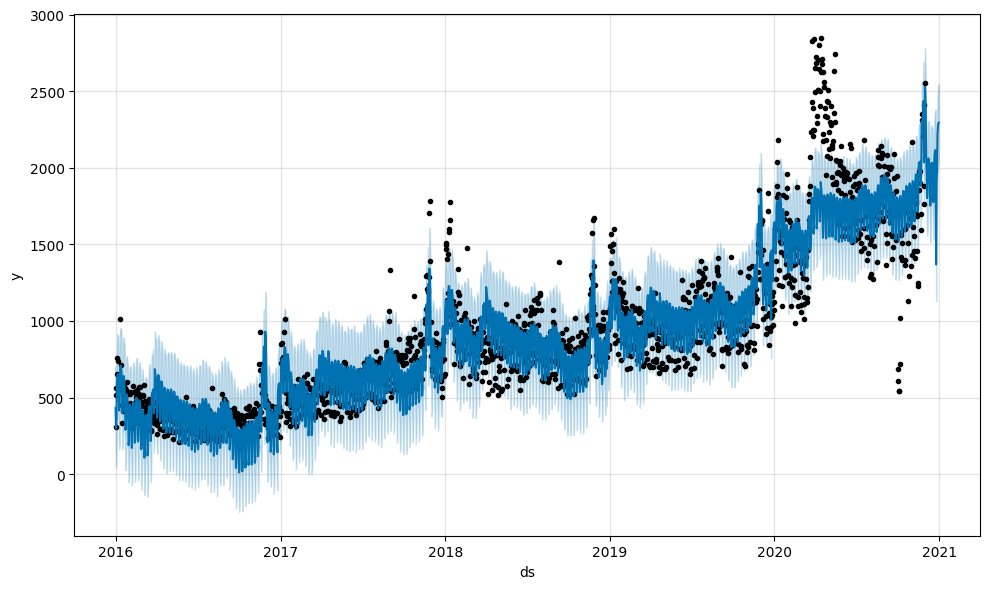

In [22]:
#Visualize the forecast
m.plot(forecast);

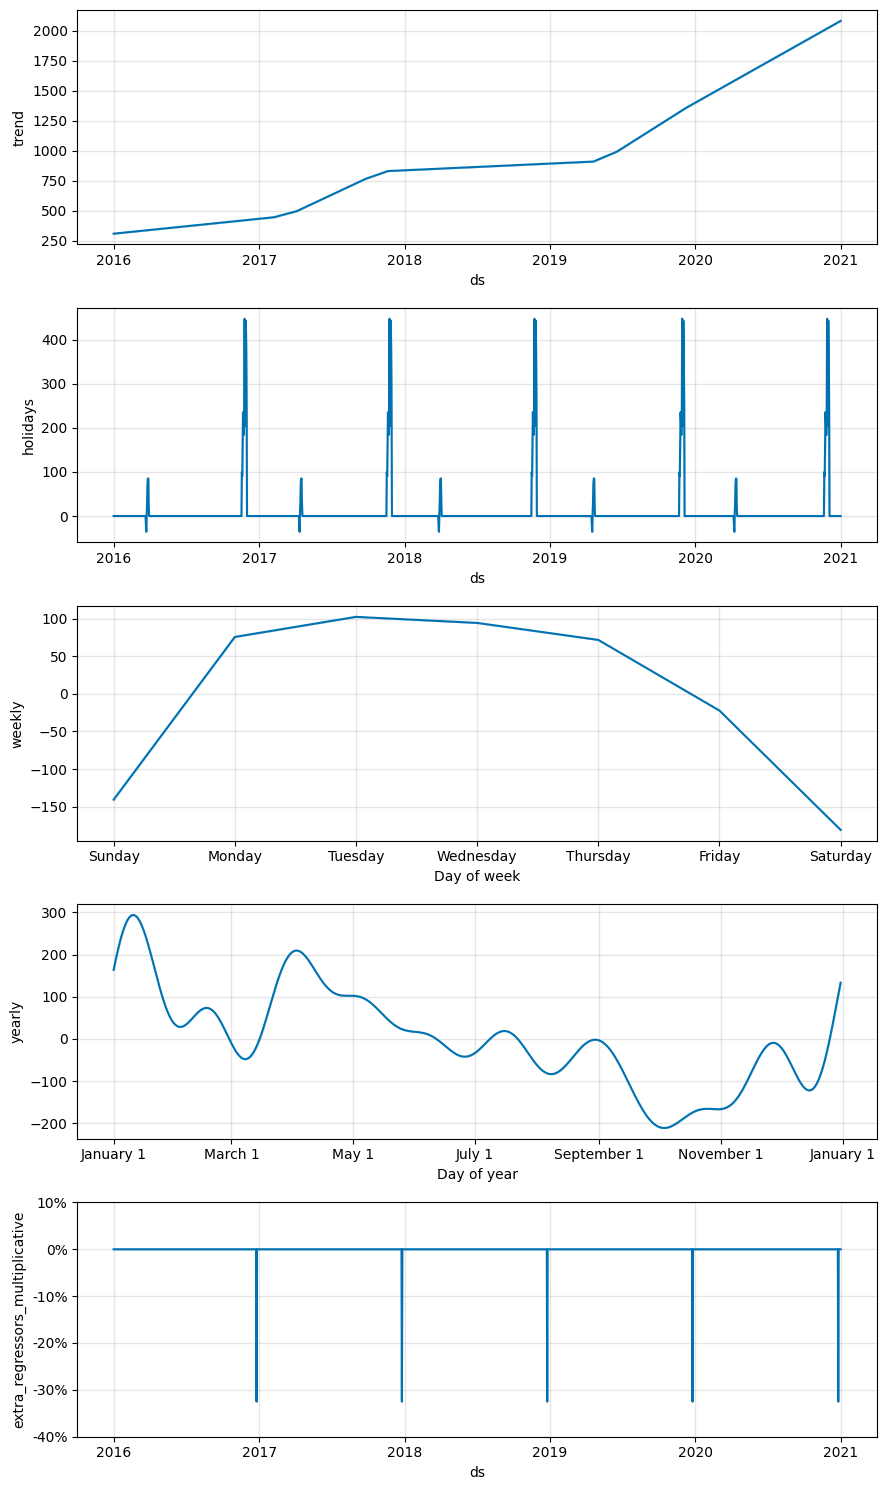

In [23]:
#plot components -> Structural Time Series decomposition
m.plot_components(forecast);

#Cross-validation

In [24]:
#CV
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m,
                        horizon = '31 days',
                        initial = '1450 days',
                        parallel = 'processes')


INFO:prophet:Making 21 forecasts with cutoffs between 2019-12-25 00:00:00 and 2020-10-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc795b0cc70>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20gq41gp/ynfh9o1f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20gq41gp/ojxvoe9q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20gq41gp/34b8jfx8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74105', 'data', 'file=/tmp/tmp20gq41gp/ynfh9o1f.json', 'init=/tmp/tmp20gq41gp/34b8jfx8.json', 'output', 'file=/tmp/tmp20gq41gp/prophet_modelvg4uhi99/prophet_model-20230502143810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20gq41gp/fcl5iwm1.json
14:38:10 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmdstanpy:idx 0
INFO:cmdstanpy:Chain [

In [25]:
#Output of the CV
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-12-26,1283.904639,1150.306568,1414.550114,1165,2019-12-25
1,2019-12-27,1225.347896,1085.390735,1367.008659,1111,2019-12-25
2,2019-12-28,1104.061400,965.758212,1238.239153,1038,2019-12-25
3,2019-12-29,1165.969900,1038.726193,1299.988336,971,2019-12-25
4,2019-12-30,1374.564180,1232.673080,1514.077298,1192,2019-12-25


In [26]:
df.shape

(1827, 3)

In [27]:
#Error Assessment

print(mean_absolute_error(df_cv['y'], df_cv['yhat']))
print(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])))

397.58625790524655
515.3769002846452


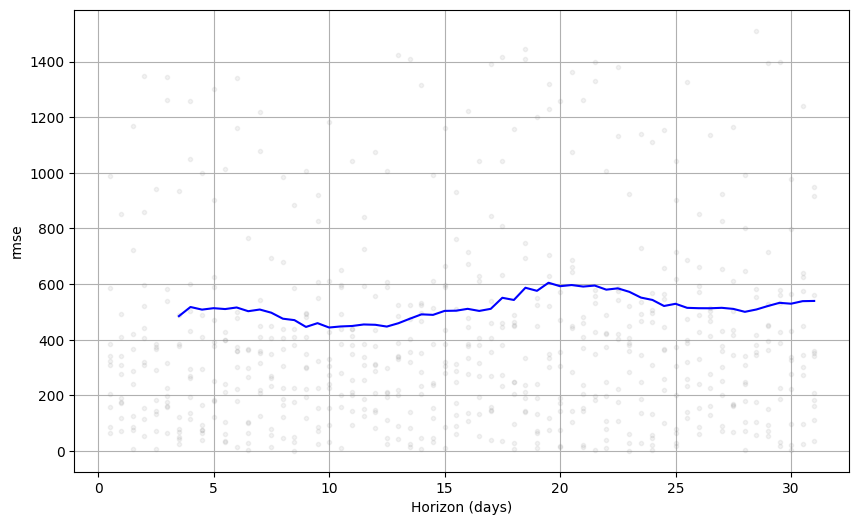

In [28]:
#CV Visualization
from prophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv,
                             metric = 'rmse');

#Parameter tuning

In [29]:
#Parameter Grid
from sklearn.model_selection import ParameterGrid
param_grid = {'seasonality_mode':['additive, multiplicative'],
              'seasonality_prior_scale':[5,10,20],
              'holidays_prior_scale':[5,10,20],
              'changepoint_prior_scale': [0.01, 0.05, 0.1]}
grid = ParameterGrid(param_grid)
len(list(grid))

27

In [30]:
#Empty list to store results
rmse = [ ]
#start the loop
for params in grid:

 #build the model
  m = Prophet(growth = 'linear',
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = params['seasonality_mode'],
            seasonality_prior_scale = params['seasonality_prior_scale'],
            holidays_prior_scale = params['holidays_prior_scale'],
            changepoint_prior_scale = params['changepoint_prior_scale'])
  m.add_regressor('Christmas', mode = 'multiplicative')
  m.fit(training)

  #Cross-Validation
  df_cv = cross_validation(m,
                           horizon = '31 days',
                           initial = '1450 days',
                           parallel = 'processes')
  #Measure and store results
  error = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))
  rmse.append(error)


ValueError: ignored

In [ ]:
#Get the best parameters
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results

#Challenge: predicting the demand for shelter in NYC

# Directory, Libraries and data

In [ ]:
%cd /content/drive/MyDrive/Business Analyst course/Predictive Analytics/Prophet

In [ ]:
#import libraries
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.utilities import regressor_coefficients
from sklearn.metrics import mean_squared_error
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import ParameterGrid

In [ ]:
#data
df = pd.read_csv("DHS_weekly.csv")
df.head()

In [ ]:
#date variable and rename date and Y
df.Date = pd.to_datetime(df.Date,
                         format = "%m/%d/%Y")
df = df.rename(columns = {'Date':'ds',
                          'Total Individuals in Shelter': 'y'})
df.head(1)

#Holidays

In [ ]:
#Easter
easter_dates = df[df.Easter == 1].ds
easter = pd.DataFrame({'holiday': 'easter',
                      'ds':easter_dates,
                      'lower_window': -7,
                      'upper_window': 7})


In [ ]:
#Thanksgiving
thanksgiving_dates = df[df.Thanksgiving == 1].ds
thanksgiving = pd.DataFrame({'holiday': 'thanksgiving',
                      'ds':thanksgiving_dates,
                      'lower_window': -7,
                      'upper_window':7})

In [ ]:
#combine events
holidays = pd.concat([easter, thanksgiving])
holidays

In [ ]:
#finish df -> remove duplicated holidays
df = df.drop(columns = ["Easter", "Thanksgiving"])
df.head(0)

#Prophet Model

In [ ]:
#Training and test split
test_weeks = 4
training = df.iloc[:-4,:]
test = df.iloc[:-4, :]
test

In [ ]:
#Prophet model
m = Prophet(growth = 'linear',
            yearly_seasonality = True,
            weekly_seasonality = False,
            holidays = holidays,
            seasonality_mode = "multiplicative",
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05)
m.add_regressor('Christmas')
m.add_regressor('Temperature')
m.fit(training)

In [ ]:
#Coefficients
regressor_coefficients(m)

Temperature is negative -> the warmer it is, the least demand we have for shelters

#Forecasting

In [ ]:
#future dataframe
future = m.make_future_dataframe(periods = test_weeks,
                                 freq = "W")
future = pd.concat([future,df.iloc[:,2:]], axis = 1)
future.tail()

In [ ]:
#forecasting
forecast = m.predict(future)

In [ ]:
#holidays
holiday = 'thanksgiving'
forecast[(forecast[holiday].abs() > 0) & (forecast['ds'] > '2020-01-01')][['ds', holiday]] 

In [ ]:
#retrieve the predictions
predictions = forecast.yhat[-test_weeks:]
predictions

In [ ]:
#accuracy assessment
np.sqrt(mean_squared_error(test['y'], predictions))

#Visualization

In [ ]:
#Plot forecast
m.plot(forecast);

In [ ]:
#model components
m.plot_components(forecast);

#Cross-Validation

In [ ]:
df_cv = cross_validation(m,
                         horizon = "4 W", # 28 days also possible
                         initial = "300 W", # 1500 days
                         parallel = 'processes')
df_cv

In [ ]:
#CV output
df_cv

In [ ]:
#CV visualization
plot_cross_validation_metric(df_cv, metric = "mape");

#Parameter Tuning

In [ ]:
#Parameter Grid
param_grid = {'seasonality_mode': ['additive','multiplicative'],
              'seasonality_prior_scale':[5,10,20],
              'holidays_prior_scale':[5,10,20],
              'changepoint_prior_scale':[0.01,0.05,0.1]}
grid = ParameterGrid(param_grid)
len(list(grid))

In [35]:
#Parameter list
rmse = []

#Loop
for params in grid:
  #build the model
  m = Prophet(growth = 'linear',
              yearly_seasonality = True,
              weekly_seasonality = False,
              holidays = holidays,
              seasonality_mode = params['seasonality_mode'],
              seasonality_prior_scale = params['seasonality_prior_scale'],
              holidays_prior_scale = params['holidays_prior_scale'],
              changepoint_prior_scale = params['changepoint_prior_scale'])
  m.add_regressor('Christmas')
  m.add_regressor('Temperature')
  m.fit(training)
  #CV
  df_cv = cross_validation(m,
                         horizon = "4 W", # 28 days also possible
                         initial = "300 W", # 1500 days
                         parallel = 'processes')

  #Measure and store the error
  error = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))
  rmse.append(error)

ValueError: ignored

In [31]:
rmse

[]

In [33]:
#get the best paramerers
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results

ValueError: ignored